# GradCAM - Gradient Class Activation Map

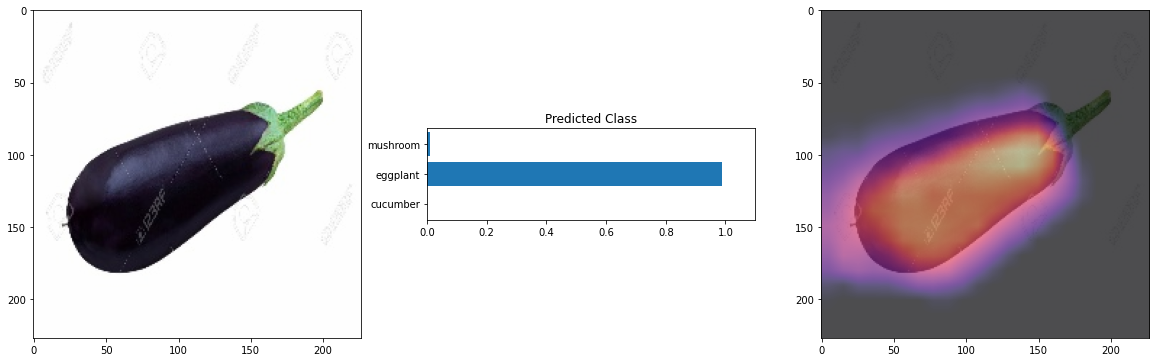

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 29.11 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-qjvfc8mv
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-qjvfc8mv
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [2]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

import torch 
from torch import nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets, transforms as T

from tqdm import tqdm 
import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [5]:
DEVICE

'cuda'

In [6]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [7]:
# Label: cucumber - 0, eggplant - 1, mushroom - 2
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)

# Augmentations

In [8]:
train_augs = A.Compose([
      A.Rotate(),
      A.HorizontalFlip(0.5),
      A.VerticalFlip(0.5),
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
valid_augs = A.Compose([
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Image Dataset 

In [9]:
trainset = utils.ImageDataset(df=train_df, augs=train_augs, data_dir=DATA_DIR)
validset = utils.ImageDataset(df=valid_df, augs=valid_augs, data_dir=DATA_DIR)

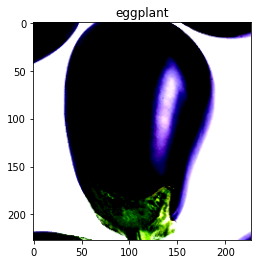

In [12]:
image, label = trainset[5]  # image in Torch.Tensor, shape=(c, h, w)

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [13]:
print(f"No. of examples in the trainset: {len(trainset)}")
print(f"No. of examples in the validset: {len(validset)}")

No. of examples in the trainset: 148
No. of examples in the validset: 38


# Load Dataset into Batches

In [14]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [16]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model 

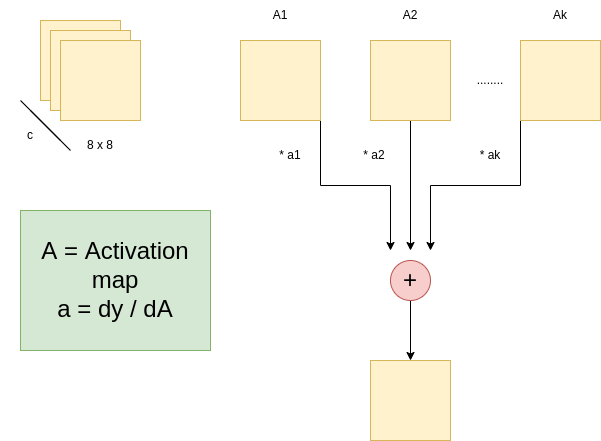

In [17]:
class ImageModel(nn.Module):
  def __init__(self) -> None:
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
            nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size=(4, 4), stride=2)
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
    )
    self.gradient = None
  
  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images)  # use as activation maps -> multiply weights(*a1) w/ activation maps
    
    h = x.register_hook(self.activations_hook)

    x = self.maxpool(x)
    x = self.classifier(x)
    return x
  
  def get_activation_gradients(self): # return gradient a1, a2, ..., ak
    return self.gradient
  
  def get_activation(self, x):  # return activation A1, A2, ..., Ak
    return self.feature_extractor(x)  # shape=(64, 8, 8) as (c, h, w)

In [19]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [20]:
def train_fn(dataloader: DataLoader, model: ImageModel, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)  # no activation
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [21]:
def eval_fn(dataloader: DataLoader, model: ImageModel, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits = model(images)  # no activation
    loss = criterion(logits, labels)

    total_loss += loss.item()
  return total_loss/len(dataloader)

# Training Loop

In [22]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [23]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print('SAVE_WEIGHT_SUCCESS')
  
  print(f'EPOCH: {i+1} \t TRAIN_LOSS: {train_loss} \t VALID_LOSS: {valid_loss}')

100%|██████████| 3/3 [00:00<00:00, 24.94it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 1 	 TRAIN_LOSS: 1.1461467385292052 	 VALID_LOSS: 1.0957546631495159


100%|██████████| 3/3 [00:00<00:00, 24.46it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 2 	 TRAIN_LOSS: 1.04051416516304 	 VALID_LOSS: 0.880003829797109


100%|██████████| 3/3 [00:00<00:00, 24.80it/s]


EPOCH: 3 	 TRAIN_LOSS: 0.6052812248468399 	 VALID_LOSS: 1.4759539763132732


100%|██████████| 3/3 [00:00<00:00, 25.28it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 4 	 TRAIN_LOSS: 0.8387111574411392 	 VALID_LOSS: 0.7976958254973093


100%|██████████| 3/3 [00:00<00:00, 25.69it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 5 	 TRAIN_LOSS: 0.6739969342947006 	 VALID_LOSS: 0.6829597155253092


100%|██████████| 3/3 [00:00<00:00, 26.34it/s]


EPOCH: 6 	 TRAIN_LOSS: 0.5686514347791671 	 VALID_LOSS: 0.7783073484897614


100%|██████████| 3/3 [00:00<00:00, 25.49it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 7 	 TRAIN_LOSS: 0.45241107419133186 	 VALID_LOSS: 0.5602226406335831


100%|██████████| 3/3 [00:00<00:00, 24.60it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 8 	 TRAIN_LOSS: 0.3388370364904404 	 VALID_LOSS: 0.3459680527448654


100%|██████████| 3/3 [00:00<00:00, 25.02it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 9 	 TRAIN_LOSS: 0.19222573637962342 	 VALID_LOSS: 0.23323801904916763


100%|██████████| 3/3 [00:00<00:00, 25.84it/s]


EPOCH: 10 	 TRAIN_LOSS: 0.5316540436819196 	 VALID_LOSS: 0.5128864049911499


100%|██████████| 3/3 [00:00<00:00, 24.86it/s]


EPOCH: 11 	 TRAIN_LOSS: 0.3945441724732518 	 VALID_LOSS: 0.29550659159819287


100%|██████████| 3/3 [00:00<00:00, 25.35it/s]


SAVE_WEIGHT_SUCCESS
EPOCH: 12 	 TRAIN_LOSS: 0.1777209158986807 	 VALID_LOSS: 0.1527325635155042


100%|██████████| 3/3 [00:00<00:00, 25.43it/s]


EPOCH: 13 	 TRAIN_LOSS: 0.1611624240875244 	 VALID_LOSS: 0.47890246907869977


100%|██████████| 3/3 [00:00<00:00, 24.30it/s]


EPOCH: 14 	 TRAIN_LOSS: 0.09650271907448768 	 VALID_LOSS: 0.3765221976985534


100%|██████████| 3/3 [00:00<00:00, 26.03it/s]


EPOCH: 15 	 TRAIN_LOSS: 0.05329664181917906 	 VALID_LOSS: 0.3790525980293751


100%|██████████| 3/3 [00:00<00:00, 25.81it/s]


EPOCH: 16 	 TRAIN_LOSS: 0.12464340331498533 	 VALID_LOSS: 0.5174937720100085


100%|██████████| 3/3 [00:00<00:00, 26.15it/s]


EPOCH: 17 	 TRAIN_LOSS: 0.1276436814572662 	 VALID_LOSS: 0.6422100439667702


100%|██████████| 3/3 [00:00<00:00, 25.67it/s]


EPOCH: 18 	 TRAIN_LOSS: 0.3248636893928051 	 VALID_LOSS: 0.2690491204460462


100%|██████████| 3/3 [00:00<00:00, 25.54it/s]


EPOCH: 19 	 TRAIN_LOSS: 0.22802642211318017 	 VALID_LOSS: 0.225443867345651


100%|██████████| 3/3 [00:00<00:00, 25.69it/s]

EPOCH: 20 	 TRAIN_LOSS: 0.0847686527762562 	 VALID_LOSS: 0.32313284277915955


# Get GradCAM

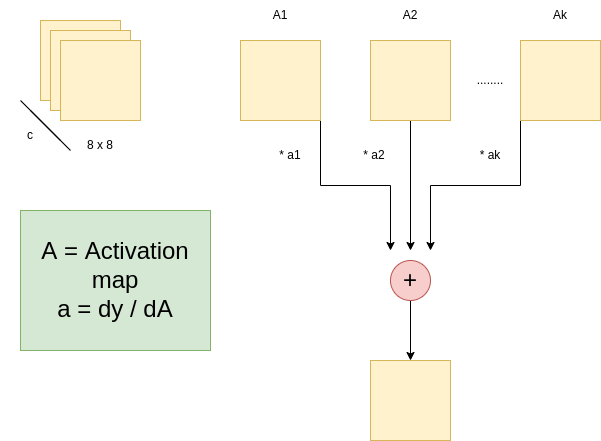

In [24]:
def get_grad_cam(model, image, label, size):
  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim=(0, 2, 3)) # get gradient weights: a1, a2, ..., ak
  activations = model.get_activation(image).detach()  # get activation map: A1, A2, ..., Ak
  
  for i in range(activations.shape[1]): # number of channel
    activations[:, i, :, :] *= pooled_gradients[i]
  
  heatmap = torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

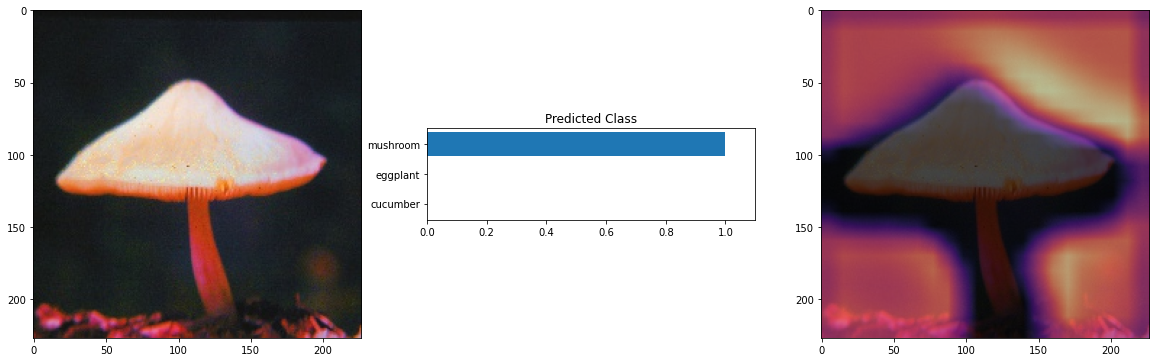

In [25]:
image, label = validset[5]

denorm_img = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
# Label: cucumber - 0, eggplant - 1, mushroom - 2
# pred[0] returns label list, pred[0][1] is eggplant
heatmap = get_grad_cam(model, image, pred[0][1], size=227)  
utils.plot_heatmap(denorm_img, pred, heatmap)